In [1]:
import warnings
import matplotlib.pyplot as plt

from pandas import DataFrame

warnings.filterwarnings("ignore")

!pip install pandas -q

import pandas as pd
# Хак чтобы работало на Anaconda под MacOs 10.15.7 Catalina
pd.DataFrame.iteritems = pd.DataFrame.items

In [2]:
!pip install plotly -q

import plotly.graph_objects as go

def linear_plot(df, title):
    fig = go.Figure([go.Scatter(x=df['date'], y=df['close'], mode='lines')])
    fig.update_layout(plot_bgcolor='white',
                      xaxis_title='Date',
                      yaxis_title='Price',
                      title=title)
    fig.show()

def candlestick_plot(df, title):
    fig = go.Figure([go.Candlestick(x=df['date'],
                                open=df['open'],
                                high=df['high'],
                                low=df['low'],
                                close=df['close'])])
    fig.update_layout(xaxis_rangeslider_visible=False,
                      plot_bgcolor='white',
                      xaxis_title='Date',
                      yaxis_title='Price',
                      title=title)
    fig.update_yaxes(fixedrange=False)
    fig.show()

In [3]:
df = pd.read_csv('ETH_USDT_1h.csv')
df = df.sort_values(by='date')
df = df.drop_duplicates(subset='date').reset_index(drop=True)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df

,open,high,low,close,volume
date,,,,,
2024-01-01 00:00:00,2281.87,2297.18,2281.27,2295.51,10771.9183
2024-01-01 01:00:00,2295.52,2306.60,2292.90,2303.72,8413.4260
2024-01-01 02:00:00,2303.72,2304.72,2291.20,2293.02,5808.2533
2024-01-01 03:00:00,2293.03,2294.50,2271.00,2273.81,10745.7360
2024-01-01 04:00:00,2273.80,2279.86,2265.24,2279.55,9681.5762
...,...,...,...,...,...
2024-12-20 08:00:00,3390.48,3390.79,3280.00,3290.29,98189.8031
2024-12-20 09:00:00,3290.29,3315.39,3260.35,3265.59,84933.0510
2024-12-20 10:00:00,3265.60,3278.00,3145.65,3186.73,142491.2678


In [5]:
df.shape

(8509, 5)

In [6]:
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [7]:
df.describe()

,open,high,low,close,volume
count,8509.000000,8509.000000,8509.000000,8509.000000,8509.000000
mean,3033.051549,3046.690777,3018.228098,3033.162819,16973.871602
std,514.293987,516.939752,511.210936,514.234278,18028.231701
min,2169.960000,2194.920000,2100.000000,2169.960000,1502.097900
25%,2544.010000,2554.000000,2534.580000,2544.020000,7111.275500
50%,3066.180000,3080.970000,3049.900000,3066.650000,11803.533000
75%,3468.910000,3485.720000,3449.390000,3468.910000,20134.410600
max,4086.660000,4107.800000,4062.600000,4086.660000,463263.532900


In [4]:
# Удалим значения где нет объемов
df = df.drop(df[df['volume']==0.0].index)

In [5]:
!pip install torch -q

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

### Baseline

#### В качестве baseline построим модель LSTM

In [8]:
data = df.copy()
data

,open,high,low,close,volume
date,,,,,
2024-01-01 00:00:00,2281.87,2297.18,2281.27,2295.51,10771.9183
2024-01-01 01:00:00,2295.52,2306.60,2292.90,2303.72,8413.4260
2024-01-01 02:00:00,2303.72,2304.72,2291.20,2293.02,5808.2533
2024-01-01 03:00:00,2293.03,2294.50,2271.00,2273.81,10745.7360
2024-01-01 04:00:00,2273.80,2279.86,2265.24,2279.55,9681.5762
...,...,...,...,...,...
2024-12-20 08:00:00,3390.48,3390.79,3280.00,3290.29,98189.8031
2024-12-20 09:00:00,3290.29,3315.39,3260.35,3265.59,84933.0510
2024-12-20 10:00:00,3265.60,3278.00,3145.65,3186.73,142491.2678


In [7]:
data = df.copy()
window_size = 30
X, y = [], []
for i in range(len(data) - window_size - 1):
    X.append(data.iloc[i:i + window_size].values)

    if data['close'].iloc[i + window_size] > data['close'].iloc[i + window_size - 1]:
        y.append(2)  # Buy
    elif data['close'].iloc[i + window_size] < data['close'].iloc[i + window_size - 1]:
        y.append(0)  # Sell
    else:
        y.append(1)  # Hold

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

In [12]:
X

tensor([[[  2281.8701,   2297.1799,   2281.2700,   2295.5100,  10771.9180],
         [  2295.5200,   2306.6001,   2292.8999,   2303.7200,   8413.4258],
         [  2303.7200,   2304.7200,   2291.2000,   2293.0200,   5808.2534],
         ...,
         [  2382.9600,   2388.6101,   2371.4700,   2386.4299,  16262.0977],
         [  2386.4199,   2390.4399,   2378.5801,   2387.6599,  12124.3340],
         [  2387.6599,   2392.3999,   2377.1799,   2377.4800,  14852.3145]],

        [[  2295.5200,   2306.6001,   2292.8999,   2303.7200,   8413.4258],
         [  2303.7200,   2304.7200,   2291.2000,   2293.0200,   5808.2534],
         [  2293.0300,   2294.5000,   2271.0000,   2273.8101,  10745.7363],
         ...,
         [  2386.4199,   2390.4399,   2378.5801,   2387.6599,  12124.3340],
         [  2387.6599,   2392.3999,   2377.1799,   2377.4800,  14852.3145],
         [  2377.4700,   2383.6799,   2373.8601,   2373.8601,  10223.5547]],

        [[  2303.7200,   2304.7200,   2291.2000,   2293.

In [13]:
y

tensor([0, 2, 2,  ..., 0, 0, 0])

In [15]:
def train_model(model, dataloader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

In [17]:
class StockLSTM(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, num_layers=2):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 3)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        x = self.fc(h_n[-1])
        return x

In [18]:
lstm_model = StockLSTM()
train_model(lstm_model, dataloader)

Epoch [1/10], Loss: 0.6964
Epoch [2/10], Loss: 0.7012
Epoch [3/10], Loss: 0.7026
Epoch [4/10], Loss: 0.7037
Epoch [5/10], Loss: 0.7044
Epoch [6/10], Loss: 0.7052
Epoch [7/10], Loss: 0.7064
Epoch [8/10], Loss: 0.7073
Epoch [9/10], Loss: 0.7081
Epoch [10/10], Loss: 0.7090


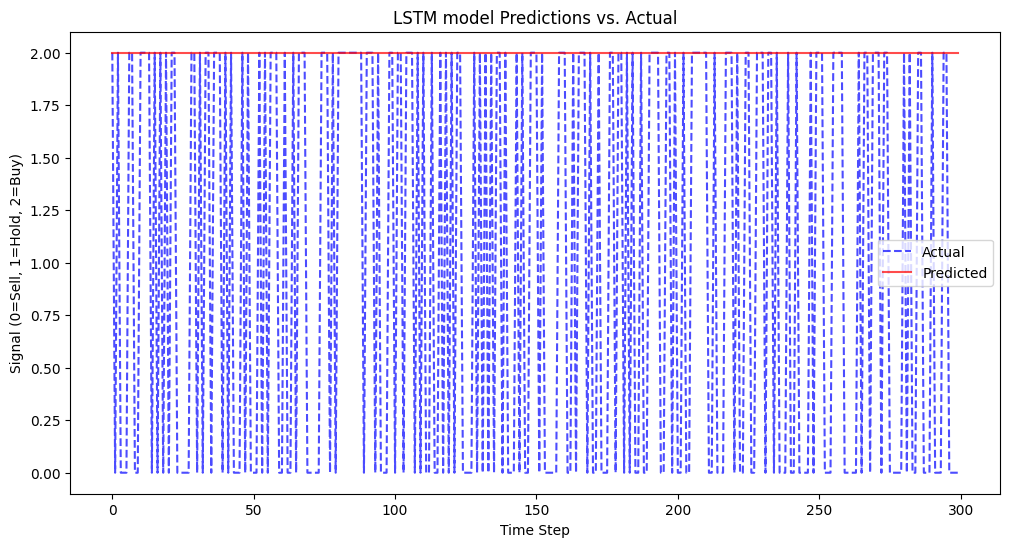

In [19]:
title="LSTM model Predictions vs. Actual"
lstm_model.eval()
all_predictions = []
all_targets = []
with torch.no_grad():
    for inputs, targets in dataloader:
        outputs = lstm_model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.numpy())
        all_targets.extend(targets.numpy())

# Plot actual vs predicted labels
plt.figure(figsize=(12, 6))
plt.plot(all_targets[-300:], label='Actual', color='blue', linestyle='--', alpha=0.7)
plt.plot(all_predictions[-300:], label='Predicted', color='red', alpha=0.7)
plt.title(title)
plt.xlabel("Time Step")
plt.ylabel("Signal (0=Sell, 1=Hold, 2=Buy)")
plt.legend()
plt.show()

In [20]:
class StockGRU(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, num_layers=2):
        super(StockGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 3)

    def forward(self, x):
        _, h_n = self.gru(x)
        x = self.fc(h_n[-1])
        return x

In [21]:
gru_model = StockGRU()
train_model(gru_model, dataloader)

Epoch [1/10], Loss: 0.6919
Epoch [2/10], Loss: 0.6941
Epoch [3/10], Loss: 0.6951
Epoch [4/10], Loss: 0.6988
Epoch [5/10], Loss: 0.7023
Epoch [6/10], Loss: 0.7040
Epoch [7/10], Loss: 0.7035
Epoch [8/10], Loss: 0.7040
Epoch [9/10], Loss: 0.7055
Epoch [10/10], Loss: 0.7073


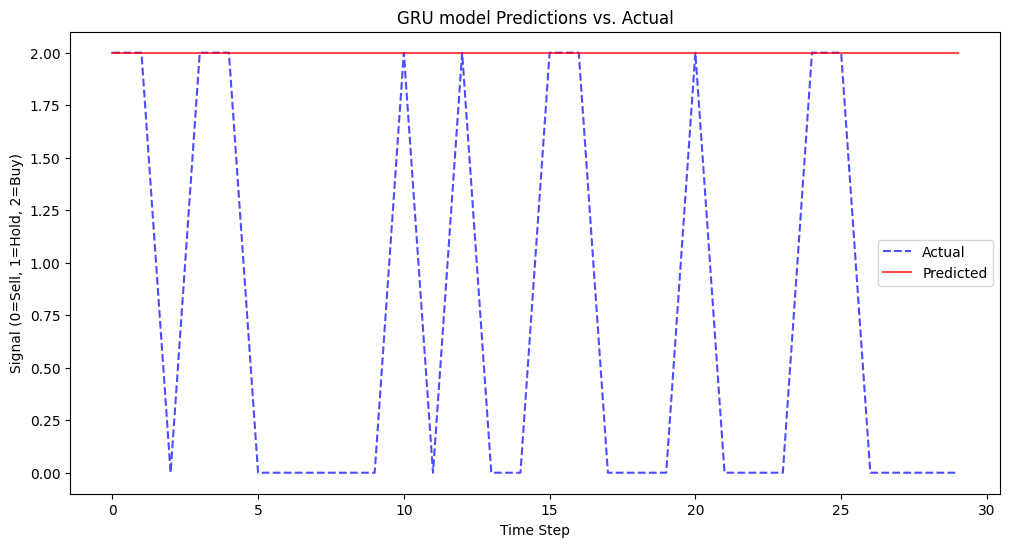

In [22]:
title="GRU model Predictions vs. Actual"
gru_model.eval()
all_predictions = []
all_targets = []
with torch.no_grad():
    for inputs, targets in dataloader:
        outputs = gru_model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.numpy())
        all_targets.extend(targets.numpy())

# Plot actual vs predicted labels
plt.figure(figsize=(12, 6))
plt.plot(all_targets[-30:], label='Actual', color='blue', linestyle='--', alpha=0.7)
plt.plot(all_predictions[-30:], label='Predicted', color='red', alpha=0.7)
plt.title(title)
plt.xlabel("Time Step")
plt.ylabel("Signal (0=Sell, 1=Hold, 2=Buy)")
plt.legend()
plt.show()

In [23]:
class StockCNN(nn.Module):
    def __init__(self):
        super(StockCNN, self).__init__()
        self.conv1 = nn.Conv1d(5, 16, kernel_size=3)  # Input: 5 channels, Output: 16 channels
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3)  # Input: 16 channels, Output: 32 channels
        self.fc1 = nn.Linear(32 * (window_size - 4), 64)  # Flattened size after conv
        self.fc2 = nn.Linear(64, 3)  # Output: 3 classes (Buy, Hold, Sell)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Permute to (batch_size, channels, sequence_length) -> [32, 5, 30]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the output from convolution layers
        x = torch.relu(self.fc1(x))
        return self.fc2(x)  # Return logits (raw output) for each class

In [24]:
# Choose model
model = StockCNN()  # Replace with StockLSTM(), StockGRU(), etc.
train_model(model, dataloader)

Epoch [1/10], Loss: 20.4238
Epoch [2/10], Loss: 6.0299
Epoch [3/10], Loss: 5.5957
Epoch [4/10], Loss: 4.1359
Epoch [5/10], Loss: 3.2956
Epoch [6/10], Loss: 1.8684
Epoch [7/10], Loss: 1.1352
Epoch [8/10], Loss: 1.2677
Epoch [9/10], Loss: 1.3444
Epoch [10/10], Loss: 1.5786


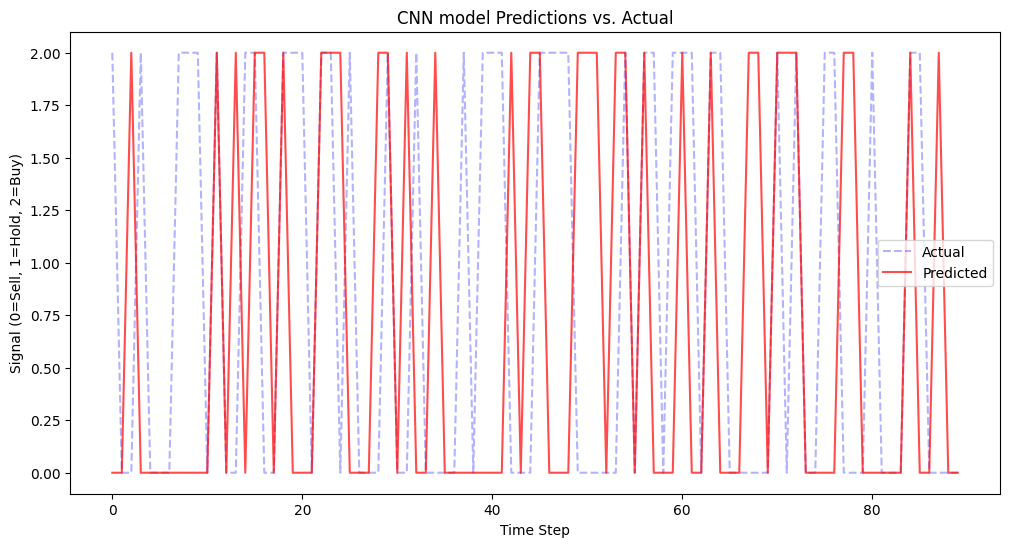

In [25]:
title="CNN model Predictions vs. Actual"
model.eval()
all_predictions = []
all_targets = []
with torch.no_grad():
    for inputs, targets in dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.numpy())
        all_targets.extend(targets.numpy())

# Plot actual vs predicted labels
plt.figure(figsize=(12, 6))
plt.plot(all_targets[-90:], label='Actual', color='blue', linestyle='--', alpha=0.3)
plt.plot(all_predictions[-90:], label='Predicted', color='red', alpha=0.7)
plt.title(title)
plt.xlabel("Time Step")
plt.ylabel("Signal (0=Sell, 1=Hold, 2=Buy)")
plt.legend()
plt.show()

### Попробуем более продвинутые модели

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler